# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, SimpleRNN, LSTM
import seaborn as sb

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [389]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
#!kaggle datasets download -d khaledzsa/traffic-dataset
#!unzip traffic-dataset.zip
df = pd.read_csv('Traffic Data.csv')#, index_col = 'date_time', parse_dates = True)

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

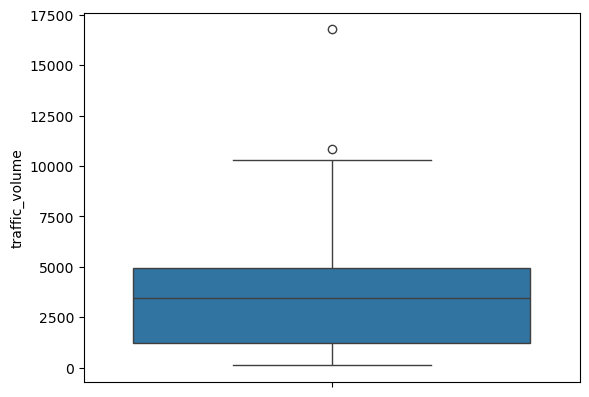

In [392]:
#Checking for outliyes
sb.boxplot(df['traffic_volume']);

In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [396]:
df.duplicated().sum()

12

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [413]:
#bfill null values
df = df.bfill()

In [415]:
#Outliyers remover function
q1 = df['traffic_volume'].quantile(0.25)
q3 = df['traffic_volume'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[df['traffic_volume'] >= lower_bound]
df = df[df['traffic_volume'] <= upper_bound]

In [417]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19998 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19998 non-null  float64
 1   temp                 19998 non-null  float64
 2   rain_1h              19998 non-null  float64
 3   snow_1h              19998 non-null  float64
 4   clouds_all           19998 non-null  int64  
 5   weather_main         19998 non-null  object 
 6   weather_description  19998 non-null  object 
 7   date_time            19998 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.4+ MB


In [419]:
#Keep only traffic_volume column, convert to date_time and sort by date_time
df = df.drop(columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'])
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values(by = 'date_time')

In [421]:
#There are data with duplicate date and value that must be get rid of
df.duplicated().sum()

3721

In [423]:
#There are data with duplicate date and value that must be get rid of
df = df.drop_duplicates()

In [427]:
#I did not know to to plot the graphs but I successfully made the function
from statsmodels.tsa.seasonal import seasonal_decompose

show = seasonal_decompose(df['traffic_volume'], model='multiplicative', filt=None, period = 5, two_sided=True, extrapolate_trend=0)
show

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [429]:
#Create shift column and change column to calculate the difference
df['prev_traffic_volume'] = df['traffic_volume'].shift(-1)
df['change'] = df['traffic_volume'] - df['prev_traffic_volume']

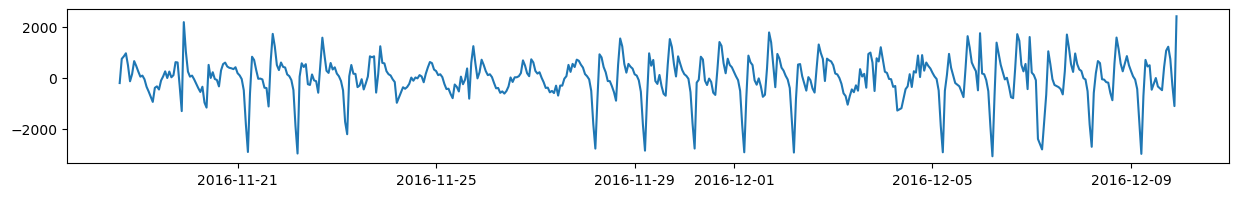

In [431]:
#Plotting change
plt.figure(figsize = (15,2))
plt.plot(df['date_time'].iloc[:500], df['change'].iloc[:500]);

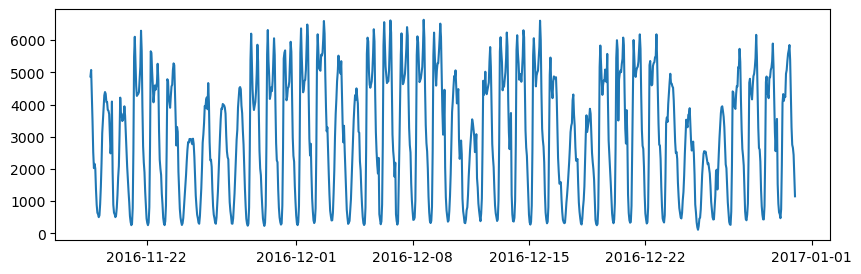

In [433]:
#Plotting data
df_1000 = df.iloc[:1000]
plt.figure(figsize = (10,3))
plt.plot(df_1000['date_time'], df_1000['traffic_volume']);

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [308]:
dataset = df['traffic_volume'].values

In [310]:
cut = int(len(dataset) * .77)

In [312]:
train = dataset[:cut]
test = dataset[cut:]

In [314]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [317]:

scaler = MinMaxScaler()

train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [320]:
def create_dataset(dataset, steps_back):
    
    X = np.array([dataset[i:i + steps_back] for i in range(len(dataset) - steps_back)])
    y = dataset[steps_back:]
    return X, y

In [322]:
X_train, y_train = create_dataset(train, 1)
X_test, y_test = create_dataset(test, 1)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [325]:
model_lstm = Sequential()
model_lstm.add(LSTM(2, return_sequences = True, input_shape = (1, 1)))
model_lstm.add(LSTM(4, return_sequences = False))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer = 'adam', loss = 'mae')

model_lstm.summary()

C:\Users\gemar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 1, 2)                │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 4)                   │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149 (596.00 B)

 Trainable params: 149 (596.00 B)

 Non-trainable params: 0 (0.00 B)

In [327]:
history_lstm = model_lstm.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_split = .25)

Epoch 1/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.3180 - val_loss: 0.1483
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1205 - val_loss: 0.0786
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0797 - val_loss: 0.0784
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0806 - val_loss: 0.0782
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0793 - val_loss: 0.0781
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0805 - val_loss: 0.0782
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0803 - val_loss: 0.0781
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0801 - val_loss: 0.0783
Epoch 9/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0790 - val_loss: 0.0781
Epoch 10/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0788 - val_loss: 0.0781
Epoch 11/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0790 - val_loss: 0.0780
Epoch 12/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

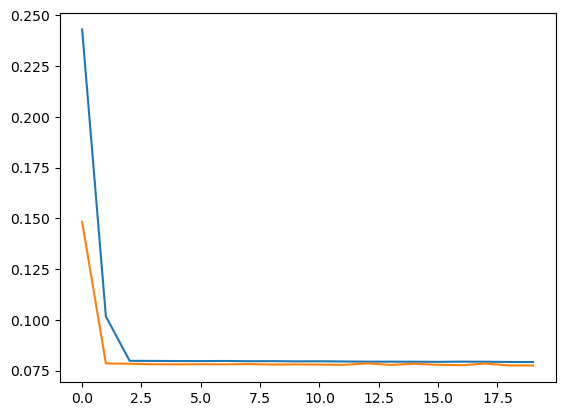

In [329]:
#Plotting loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss']);

In [330]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_train_lstm = model_lstm.predict(X_train)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


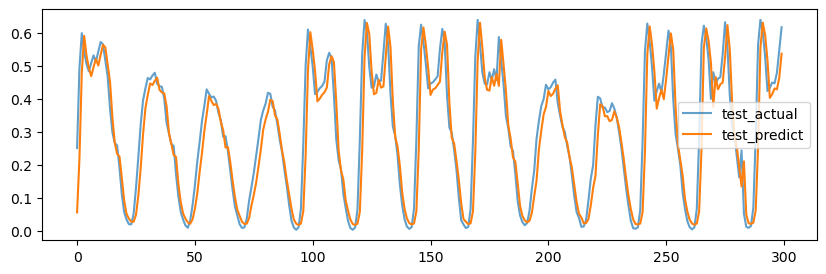

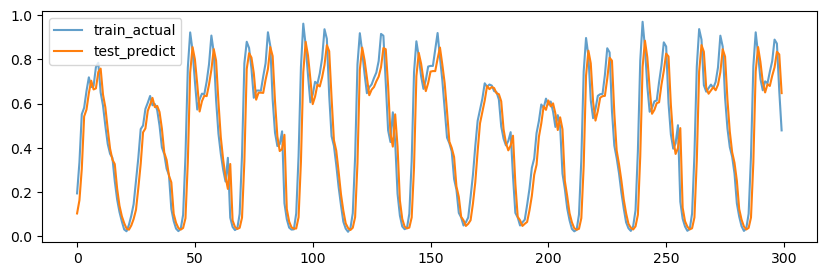

In [331]:
#Test on random sample (3000:3300)
plt.figure(figsize = (10,3))
plt.plot(y_test[3000:3300], label = 'test_actual', alpha = .7)
plt.plot(y_pred_lstm[3000:3300], label = 'test_predict')
plt.legend();

#Train
plt.figure(figsize = (10,3))
plt.plot(y_train[3000:3300], label = 'train_actual', alpha = .7)
plt.plot(y_pred_train_lstm[3000:3300], label = 'test_predict')
plt.legend();

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [333]:
loss = model_lstm.evaluate(X_test,y_test)
print("Mean Absolute Error: %.2f%%" % (loss*100))

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0580
Mean Absolute Error: 5.70%


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [335]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(4, return_sequences = True, input_shape = (1, 1)))
model_rnn.add(SimpleRNN(4, return_sequences = True))
model_rnn.add(SimpleRNN(4, return_sequences = False))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer = 'adam', loss = 'mae')

model_rnn.summary()

C:\Users\gemar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_15 (SimpleRNN)            │ (None, 1, 4)                │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_16 (SimpleRNN)            │ (None, 1, 4)                │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_17 (SimpleRNN)            │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [338]:
history_rnn = model_rnn.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_split = .25)

Epoch 1/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4465 - val_loss: 0.1464
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1025 - val_loss: 0.0801
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0822 - val_loss: 0.0797
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0815 - val_loss: 0.0808
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0812 - val_loss: 0.0801
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0813 - val_loss: 0.0813
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0813 - val_loss: 0.0795
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0817 - val_loss: 0.0804
Epoch 9/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0820 - val_loss: 0.0796
Epoch 10/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0817 - val_loss: 0.0796
Epoch 11/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0799 - val_loss: 0.0792
Epoch 12/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

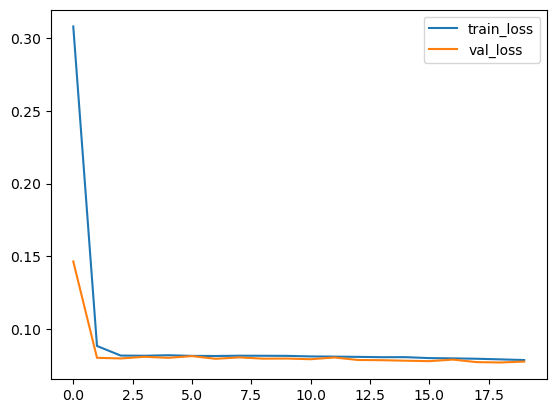

In [342]:
#Plotting loss
plt.plot(history_rnn.history['loss'], label = 'train_loss')
plt.plot(history_rnn.history['val_loss'], label = 'val_loss');
plt.legend();

In [345]:
y_pred_rnn = model_rnn.predict(X_test)
y_pred_train_rnn = model_rnn.predict(X_train)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


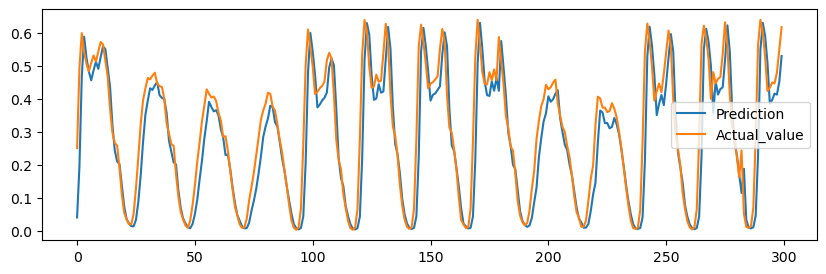

In [346]:
plt.figure(figsize = (10,3))
plt.plot(y_pred_rnn[3000:3300], label = 'Prediction')
plt.plot(y_test[3000:3300], label = 'Actual_value')
plt.legend()

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [348]:
loss_rnn = model_rnn.evaluate(X_test, y_test)
print("mean absolute error: %.2f%%" % (loss_rnn * 100))

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609
mean absolute error: 6.00%


## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: I did some feature engeneering where I created "change" that calculates the difference between traffic_volume and its previous shift. 
4. I chose this batch size because it balances between the data size and the accuracy intended.
   5. I chose mean absolute error because it calculates the loss of distances numberic values.
   6. 7 Unfortunaely, the plots return a very accurate predictions. This could indicate an error during preprocesing.